# Imports

In [1]:
import sys
sys.path.append("/home/zhhu/workspaces/deepinv/")

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from tqdm import tqdm, trange

import deepinv as dinv
from deepinv.optim.optimizers import optim_builder
from deepinv.physics.structured_random import generate_diagonal
from deepinv.utils.demo import load_url_image, get_image_url
from deepinv.utils.plotting import plot
from deepinv.optim.phase_retrieval import correct_global_phase, cosine_similarity, spectral_methods, default_preprocessing, plot_error_bars, spectral_methods_wrapper

/home/zhhu/miniconda3/envs/deepinv2/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/zhhu/miniconda3/envs/deepinv2/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/home/zhhu/miniconda3/envs/deepinv2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import matplotlib.font_manager as fm

# Replace with the actual path from fc-list output
font_path = "/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf"
fm.fontManager.addfont(font_path)

In [4]:
device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"
device

Selected GPU 0 with 32491 MiB free memory 


device(type='cuda', index=0)

In [5]:
def clean_df(df_list, start=1.8,):
    for df in df_list:
        df.dropna(inplace=True)

        rows_to_drop = []
        left = start
        for index, row in df.iterrows():
            if row["oversampling_ratio"] - left < 0.2:
                rows_to_drop.append(index)
            else:
                left = row["oversampling_ratio"]
        df.drop(rows_to_drop, inplace=True) 

# Spectrum (sorted)

In [24]:
df_gaussian = pd.read_csv("../results/full/marchenko/full_marchenko_spec.csv")
df_unitary = pd.read_csv("../results/full/unitary/full_unitary_spec.csv")
df_struct_unitary = pd.read_csv("../results/structured/unitary_fourier_uniform/structured_unitary_FDFD_spec.csv")
df_struct_marchenko = pd.read_csv("../results/structured/marchenko_fourier_uniform/structured_fourier_marchenko_FDFD_spec.csv")
df_marchenko_reverse = pd.read_csv("../results/structured/marchenko_reverse_fourier_uniform/structured_reverse_marchenko_FDFD_spec.csv")

In [25]:
clean_df([df_struct_marchenko, df_struct_unitary,df_marchenko_reverse],start=0.0)

Gaussian
(0.12156862745098039, 0.4666666666666667, 0.7058823529411765) Gaussian
Unitary
(1.0, 0.4980392156862745, 0.054901960784313725) Unitary
Structured Marchenko
(0.17254901960784313, 0.6274509803921569, 0.17254901960784313) Structured Marchenko
Structured Unitary
(0.8392156862745098, 0.15294117647058825, 0.1568627450980392) Structured Unitary
Figure saved to ../figures/spectrum.pdf


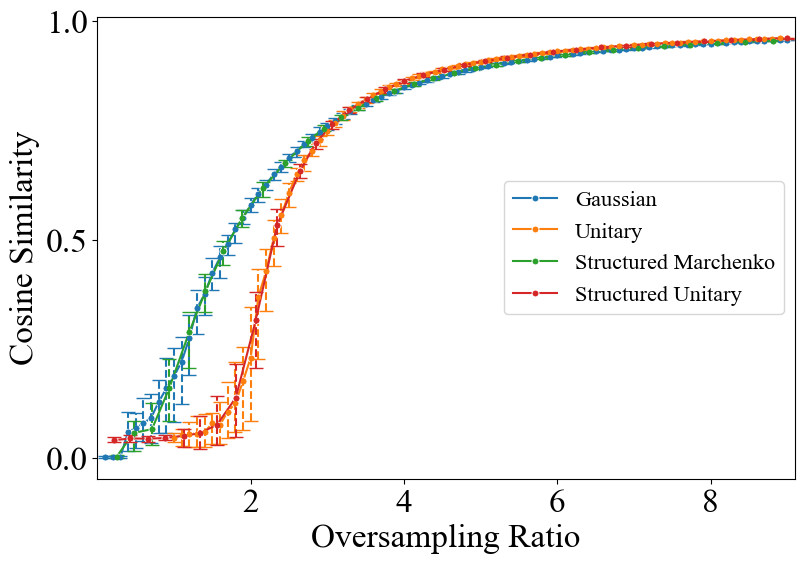

In [26]:
plot_error_bars(
    [
        df_gaussian["oversampling_ratio"],
        df_unitary["oversampling_ratio"],
        df_struct_marchenko["oversampling_ratio"],
        df_struct_unitary["oversampling_ratio"],
    ],
    [
        df_gaussian,
        df_unitary,
        df_struct_marchenko,
        df_struct_unitary,
    ],
    [
        "Gaussian",
        "Unitary",
        "Structured Marchenko",
        "Structured Unitary",
    ],
    #title="Performance Comparison of Different Number of Layers",
    #save="layers_gd_spec.svg",
    figsize=(9,6),
    plot="n_layers",
    xlim=(0.0,9.1),
    xticks=[2,4,6,8],
    yticks=[0.0,0.5,1.0],
    legend_loc="center right",
    labelsize=24,
    fontsize=16,
    save_dir='../figures/spectrum.pdf',
    ticksize=24,
    transparent=True
)

Gaussian
(0.12156862745098039, 0.4666666666666667, 0.7058823529411765) Gaussian
D2 Marchenko
(1.0, 0.4980392156862745, 0.054901960784313725) D2 Marchenko
D1 Marchenko
(0.17254901960784313, 0.6274509803921569, 0.17254901960784313) D1 Marchenko
Figure saved to ../figures/position.pdf


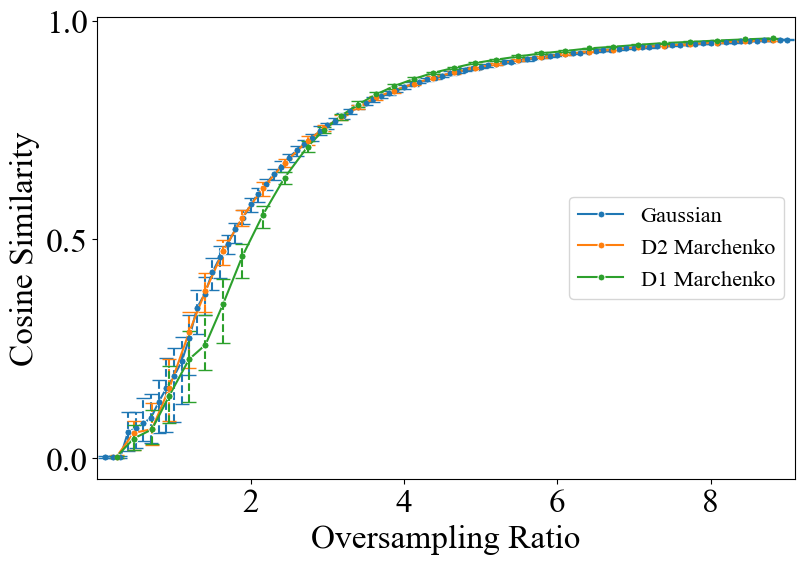

In [27]:
plot_error_bars(
    [
        df_gaussian["oversampling_ratio"],
        df_struct_marchenko["oversampling_ratio"],
        df_marchenko_reverse["oversampling_ratio"],
    ],
    [
        df_gaussian,
        df_struct_marchenko,
        df_marchenko_reverse,
    ],
    [
        "Gaussian",
        "D2 Marchenko",
        "D1 Marchenko",
    ],
    figsize=(9,6),
    plot="n_layers",
    xlim=(0.0,9.1),
    xticks=[2,4,6,8],
    yticks=[0.0,0.5,1.0],
    legend_loc="center right",
    labelsize=24,
    fontsize=16,
    save_dir='../figures/position.pdf',
    ticksize=24,
    transparent=True
)

# Diagonal Distribution (sorted)

In [ ]:
df_marchenko_uniform = pd.read_csv("../results/marchenko_fourier_uniform/res_structured_fourier_marchenko_FDFD_spec.csv")
df_marchenko_laplace = pd.read_csv("../results/marchenko_fourier_laplace/res_structured_laplace_marchenko_FDFD_spec.csv")
df_marchenko_quadrant = pd.read_csv("../results/marchenko_fourier_quadrant/res_structured_quadrant_marchenko_FDFD_spec.csv")

In [34]:
clean_df([df_marchenko_uniform, df_marchenko_laplace, df_marchenko_quadrant],start=0.0)

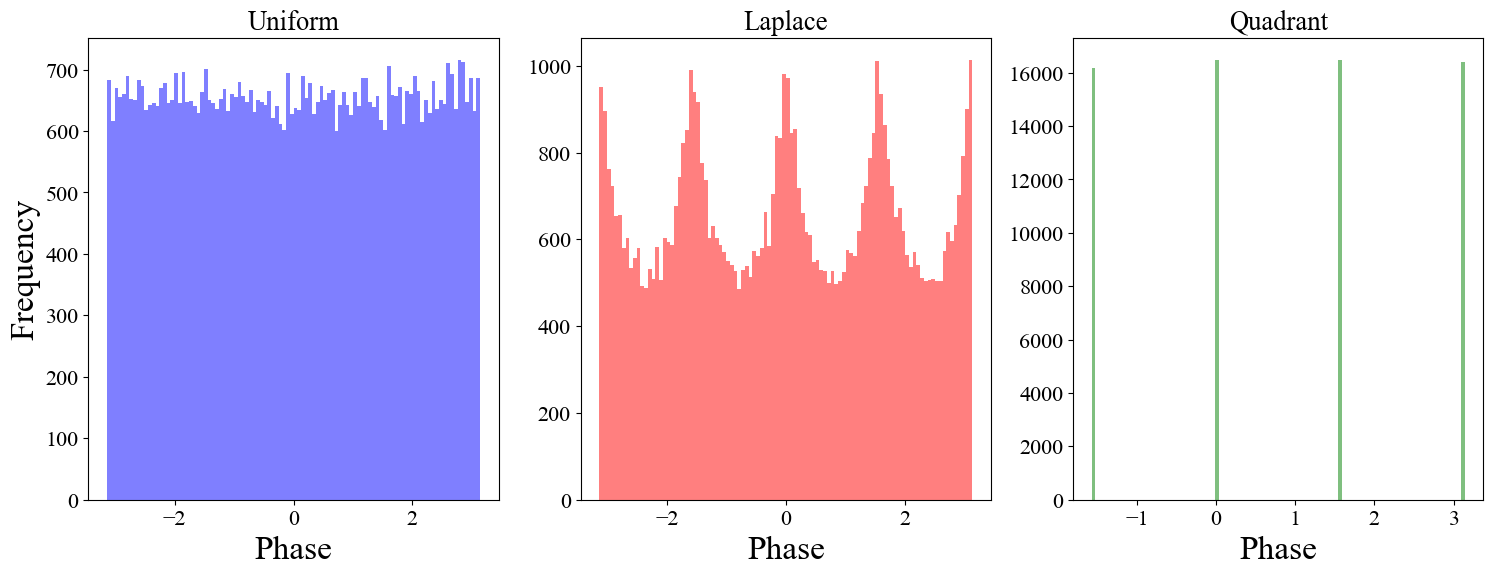

In [31]:
diagonal_uniform = generate_diagonal((256,256),['unit','uniform'])
diagonal_laplace = generate_diagonal((256,256),['unit','laplace'])
diagonal_quadrant = generate_diagonal((256,256),['unit','quadrant'])

fig, ax = plt.subplots(1,3,figsize=(18,6))
ax[0].hist(diagonal_uniform.angle().flatten(), bins=100, color='blue', alpha=0.5, label='Uniform')
ax[0].set_title('Uniform')
ax[0].set_xlabel('Phase')
ax[0].set_ylabel('Frequency')
ax[1].hist(diagonal_laplace.angle().flatten(), bins=100, color='red', alpha=0.5, label='Laplace')
ax[1].set_title('Laplace')
ax[1].set_xlabel('Phase')
ax[2].hist(diagonal_quadrant.angle().flatten(), bins=100, color='green', alpha=0.5, label='Quadrant')
ax[2].set_title('Quadrant')
ax[2].set_xlabel('Phase')
plt.savefig('../figures/diagonal_distribution.pdf', transparent=True)
plt.show()

Uniform
(0.12156862745098039, 0.4666666666666667, 0.7058823529411765) Uniform
Laplace
(1.0, 0.4980392156862745, 0.054901960784313725) Laplace
Quadrant
(0.17254901960784313, 0.6274509803921569, 0.17254901960784313) Quadrant
Figure saved to ../figures/diagonals.pdf


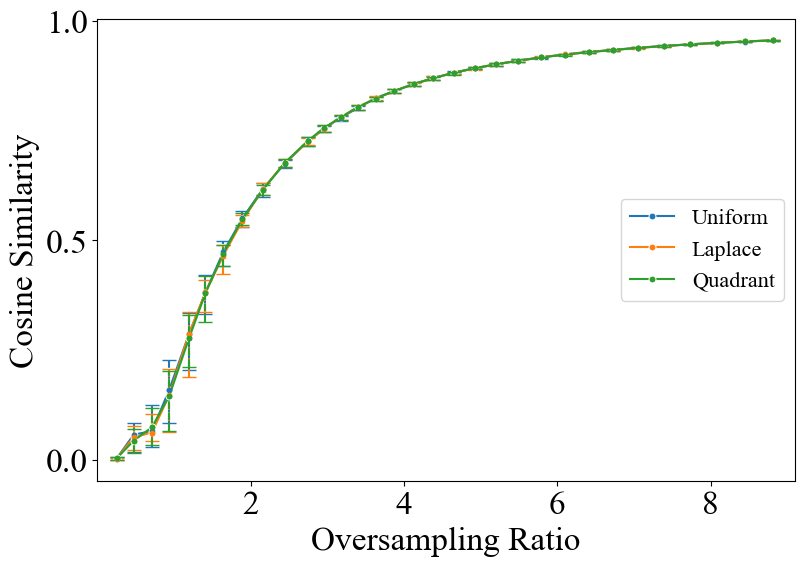

In [36]:
plot_error_bars(
    [
        df_marchenko_uniform["oversampling_ratio"],
        df_marchenko_laplace["oversampling_ratio"],
        df_marchenko_quadrant["oversampling_ratio"],
    ],
    [
        df_marchenko_uniform,
        df_marchenko_laplace,
        df_marchenko_quadrant,
    ],
    [
        "Uniform",
        "Laplace",
        "Quadrant",
    ],
    #title="Performance Comparison of Different Number of Layers",
    #save="layers_gd_spec.svg",
    figsize=(9,6),
    plot="n_layers",
    xlim=(0.0,9.1),
    xticks=[2,4,6,8],
    yticks=[0.0,0.5,1.0],
    legend_loc="center right",
    labelsize=24,
    fontsize=16,
    save_dir='../figures/diagonals.pdf',
    ticksize=24,
    transparent=True
)

# Transform (sorted)

## Gaussian, Not Padded

In [37]:
df_gaussian = pd.read_csv("../results/spectrum/full_marchenko/res_full-marchenko_shepp-logan_spec_0.10000000149011612-9.0_50repeat.csv")
df_fft = pd.read_csv("../results/marchenko_fourier_uniform/res_structured_fourier_marchenko_FDFD_spec.csv")
df_dct = pd.read_csv("../results/marchenko_cosine_uniform/res_structured_cosine_marchenko_FDFD_spec.csv")

In [38]:
clean_df([df_fft, df_dct],start=0.0)

Gaussian
(0.12156862745098039, 0.4666666666666667, 0.7058823529411765) Gaussian
FFT
(1.0, 0.4980392156862745, 0.054901960784313725) FFT
DCT
(0.17254901960784313, 0.6274509803921569, 0.17254901960784313) DCT
Figure saved to ../figures/transforms_unpadded.pdf


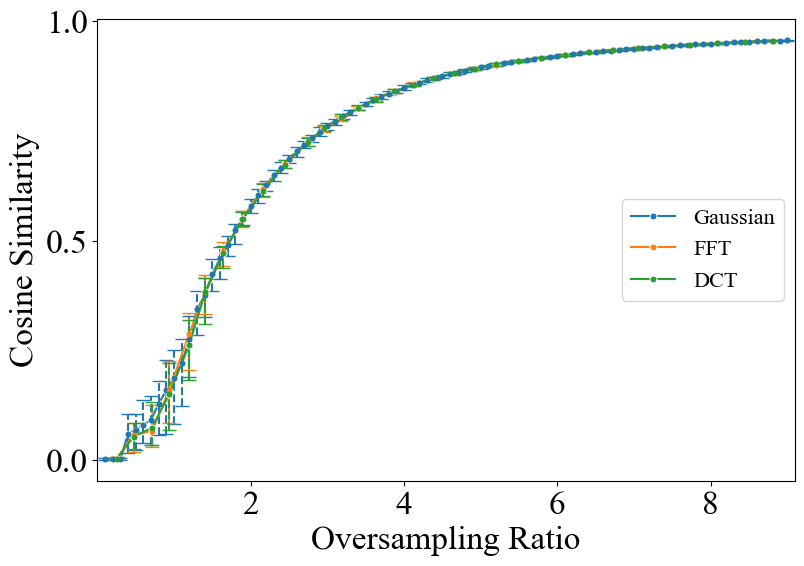

In [40]:
plot_error_bars(
    [
        df_gaussian["oversampling_ratio"],
        df_fft["oversampling_ratio"],
        df_dct["oversampling_ratio"],
    ],
    [
        df_gaussian,
        df_fft,
        df_dct,
    ],
    [
        "Gaussian",
        "FFT",
        "DCT",
    ],
    #title="Performance Comparison of Different Number of Layers",
    #save="layers_gd_spec.svg",
    figsize=(9,6),
    plot="n_layers",
    xlim=(0.0,9.1),
    xticks=[2,4,6,8],
    yticks=[0.0,0.5,1.0],
    legend_loc="center right",
    labelsize=24,
    fontsize=16,
    save_dir='../figures/transforms_unpadded.pdf',
    ticksize=24,
    transparent=True
)

## Gaussan, Padded

In [10]:
df_gaussian = pd.read_csv("../results/full/marchenko/full_marchenko_spec.csv")
df_hadamard = pd.read_csv("../results/structured/marchenko_hadamard_uniform/structured_hadamard_marchenko_FDFD_spec.csv")
df_fourier_padded = pd.read_csv("../results/structured/marchenko_fourier_padded_uniform/structured_fourier_padded_marchenko_FDFD_spec.csv")
df_cosine_padded = pd.read_csv("../results/structured/marchenko_cosine_padded_uniform/structured_cosine_padded_marchenko_FDFD_spec.csv")
df_hadamard_fourier = pd.read_csv("../runs/20241231-142300/res_structured_fourier_hadamard_FDFD_spec.csv")

In [11]:
clean_df([df_hadamard, df_hadamard_fourier, df_fourier_padded, df_cosine_padded],start=0.0)

Gaussian
(0.12156862745098039, 0.4666666666666667, 0.7058823529411765) Gaussian
Hadamard
(1.0, 0.4980392156862745, 0.054901960784313725) Hadamard
FFT Padded
(0.17254901960784313, 0.6274509803921569, 0.17254901960784313) FFT Padded
DCT Padded
(0.8392156862745098, 0.15294117647058825, 0.1568627450980392) DCT Padded
Figure saved to ../figures/transforms_padded_marchenko.pdf


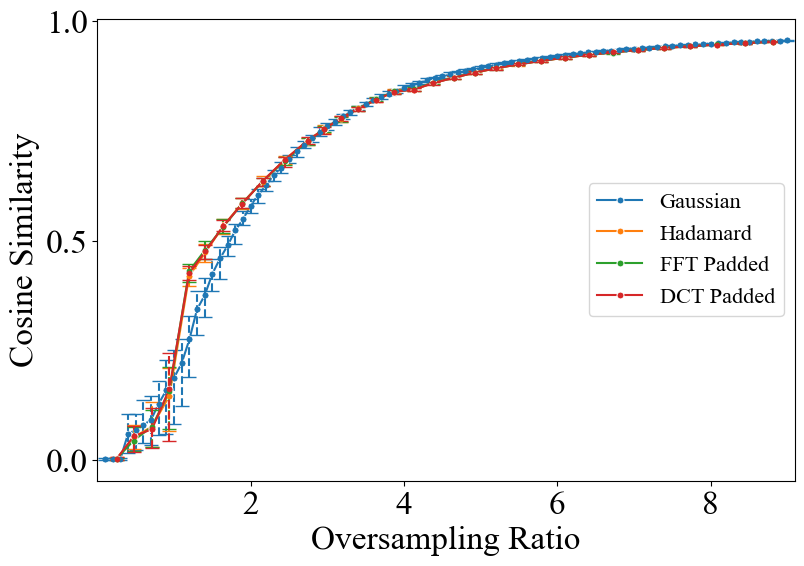

In [13]:
plot_error_bars(
    [
        df_gaussian["oversampling_ratio"],
        df_hadamard["oversampling_ratio"],
        df_fourier_padded["oversampling_ratio"],
        df_cosine_padded["oversampling_ratio"],
    ],
    [
        df_gaussian,
        df_hadamard,
        df_fourier_padded,
        df_cosine_padded,
    ],
    [
        "Gaussian",
        "Hadamard",
        "FFT Padded",
        "DCT Padded",
    ],
    #title="Performance Comparison of Different Number of Layers",
    #save="layers_gd_spec.svg",
    figsize=(9,6),
    plot="n_layers",
    xlim=(0.0,9.1),
    xticks=[2,4,6,8],
    yticks=[0.0,0.5,1.0],
    legend_loc="center right",
    labelsize=24,
    fontsize=16,
    save_dir='../figures/transforms_padded_marchenko.pdf',
    ticksize=24,
    transparent=True
)

## Unitary Padded

In [18]:
df_fft_padded_unitary = pd.read_csv("../results/structured/unitary_fourier_padded_uniform/structured_unitary_fourier_FDFD_spec.csv")
df_dct_padded_unitary = pd.read_csv("../results/structured/unitary_cosine_padded_uniform/structured_unitary_cosine_FDFD_spec.csv")
df_hadamard_unitary = pd.read_csv("../results/structured/unitary_hadamard_uniform/structured_unitary_hadamard_FDFD_spec.csv")

df_unitary = pd.read_csv("../results/full/unitary/full_unitary_spec.csv")

In [19]:
clean_df([df_fft_padded_unitary, df_dct_padded_unitary, df_hadamard_unitary],start=0.0)

Unitary
(0.12156862745098039, 0.4666666666666667, 0.7058823529411765) Unitary
FFT Padded Unitary
(1.0, 0.4980392156862745, 0.054901960784313725) FFT Padded Unitary
DCT Padded Unitary
(0.17254901960784313, 0.6274509803921569, 0.17254901960784313) DCT Padded Unitary
Hadamard Unitary
(0.8392156862745098, 0.15294117647058825, 0.1568627450980392) Hadamard Unitary
Figure saved to ../figures/transforms_padded_unitary.pdf


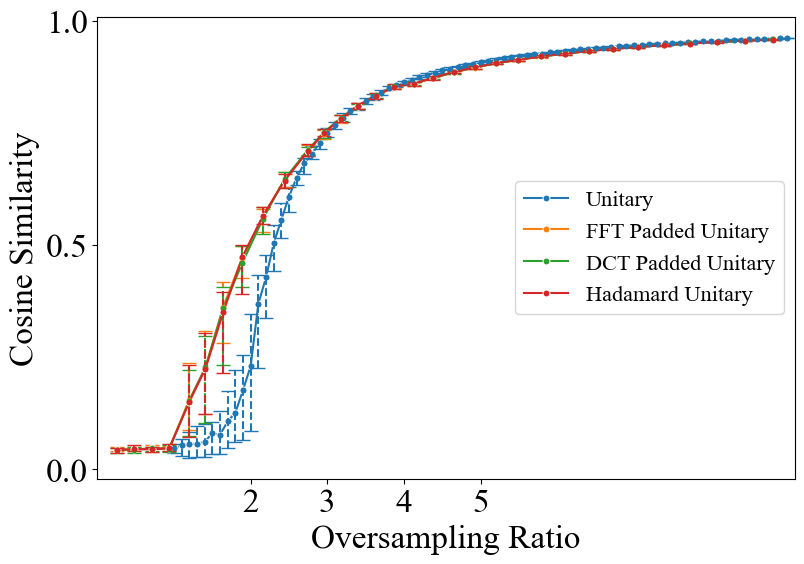

In [20]:
plot_error_bars(
    [
        df_unitary["oversampling_ratio"],
        df_fft_padded_unitary["oversampling_ratio"],
        df_dct_padded_unitary["oversampling_ratio"],
        df_hadamard_unitary["oversampling_ratio"],
    ],
    [
        df_unitary,
        df_fft_padded_unitary,
        df_dct_padded_unitary,
        df_hadamard_unitary,
    ],
    [
        "Unitary",
        "FFT Padded Unitary",
        "DCT Padded Unitary",
        "Hadamard Unitary",
    ],
    #title="Performance Comparison of Different Number of Layers",
    #save="layers_gd_spec.svg",
    figsize=(9,6),
    plot="n_layers",
    xlim=(0.0,9.1),
    xticks=[2,3,4,5],
    yticks=[0.0,0.5,1.0],
    legend_loc="center right",
    labelsize=24,
    fontsize=16,
    save_dir='../figures/transforms_padded_unitary.pdf',
    ticksize=24,
    transparent=True
)

# 1.5 Layers (sorted)

In [6]:
# try different images

df_shepp_fdf = pd.read_csv("../results/structured/fdf_shepp_fourier_uniform/fdf_shepp_FDF_spec.csv")
df_random_fdf = pd.read_csv("../results/structured/fdf_random_fourier_uniform/fdf_random_FDF_spec.csv")
df_delta_fdf = pd.read_csv("../results/structured/fdf_delta_fourier_uniform/fdf_delta_FDF_spec.csv")
df_constant_fdf = pd.read_csv("../results/structured/fdf_constant_fourier_uniform/fdf_constant_FDF_spec.csv")
df_constant_fdfd = pd.read_csv("../runs/20250219-170914/fdfd_constant_FDFD_spec.csv")
df_random_fdfd = pd.read_csv("../runs/20250219-171059/fdfd_random_FDFD_spec.csv")

df_gaussian = pd.read_csv("../results/full/marchenko/full_marchenko_spec.csv")

In [7]:
clean_df([df_shepp_fdf, df_random_fdf, df_delta_fdf, df_constant_fdf, df_constant_fdfd, df_random_fdfd], start=0.0)

Figure saved to ../figures/1-5layer.pdf


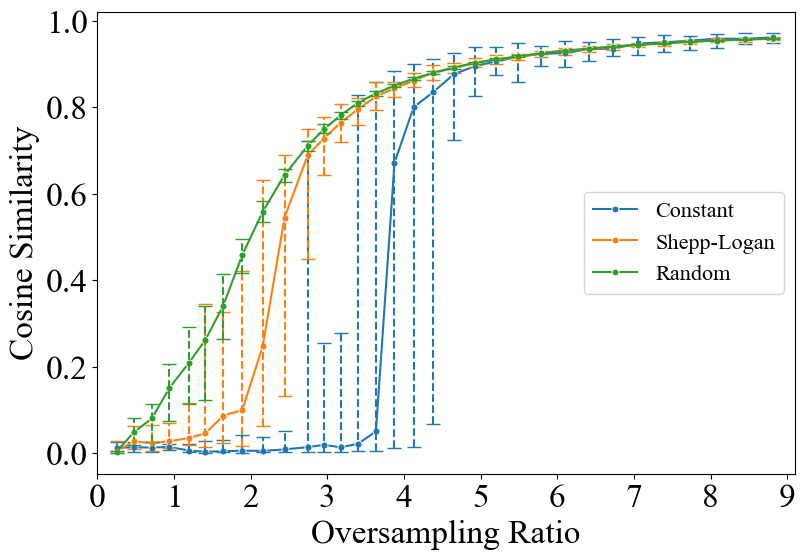

In [12]:
# different images
plot_error_bars(
    [
        df_constant_fdf["oversampling_ratio"],
        df_shepp_fdf["oversampling_ratio"],
        df_random_fdf["oversampling_ratio"],
    ],
    [
        df_constant_fdf,
        df_shepp_fdf,
        df_random_fdf,
    ],
    [
        "Constant",
        "Shepp-Logan",
        "Random",
    ],
    #title="Performance Comparison of Different Number of Layers",
    #save="layers_gd_spec.svg",
    figsize=(9,6),
    plot="n_layers",
    xlim=(0.0,9.1),
    xticks=[0,1,2,3,4,5,6,7,8,9],
    yticks=[0.0,0.2,0.4,0.6,0.8,1.0],
    legend_loc="center right",
    labelsize=24,
    fontsize=16,
    save_dir='../figures/1-5layer.pdf',
    ticksize=24,
    transparent=True
)

# Normalized Gaussian (sorted)

In [44]:
df_normalized_gaussian = pd.read_csv("../results/full_matrix/normalized_gaussian/res_full-unit_shepp-logan_spec_0.10000000149011612-5.0_50repeat.csv")
df_gaussian = pd.read_csv("../results/accuracy/res_random_spectral_100repeat_5000iter_0.10000000149011612-9.0.csv")

Gaussian
(0.12156862745098039, 0.4666666666666667, 0.7058823529411765) Gaussian
Normalized Gaussian
(1.0, 0.4980392156862745, 0.054901960784313725) Normalized Gaussian


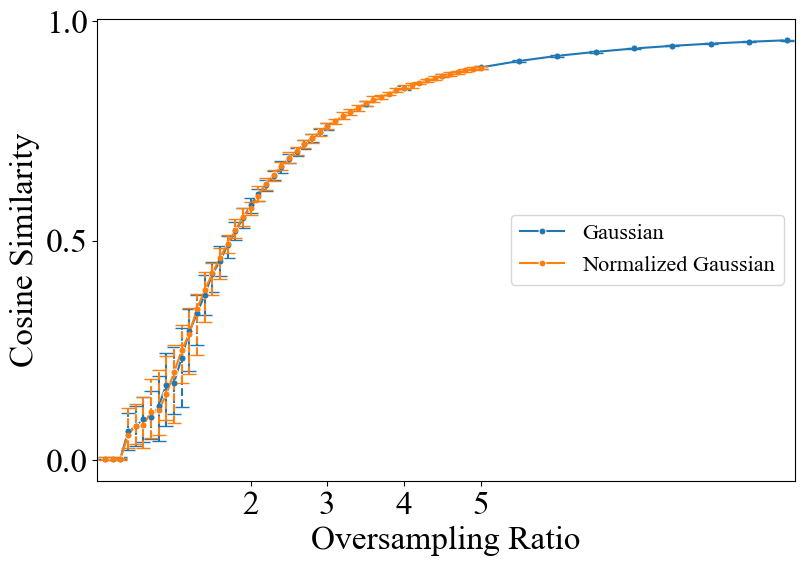

In [45]:
# plot
plot_error_bars([
        df_gaussian["oversampling_ratio"],
        df_normalized_gaussian["oversampling_ratio"],
    ],
    [
        df_gaussian,
        df_normalized_gaussian,
    ],
    [
        "Gaussian",
        "Normalized Gaussian",
    ],
    #title="Performance Comparison of Different Number of Layers",
    #save="layers_gd_spec.svg",
    figsize=(9,6),
    plot="n_layers",
    xlim=(0.0,9.1),
    xticks=[2,3,4,5],
    yticks=[0.0,0.5,1.0],
    legend_loc="center right",
    labelsize=24,
    fontsize=16,
    #save_dir='paper/figures/layers.pdf',
    ticksize=24,
    transparent=True
)

# Adversarial Input (sorted)

In [27]:
df_gaussian = pd.read_csv("../results/structured/marchenko_fourier_uniform/structured_fourier_marchenko_FDFD_spec.csv")
df_unitary = pd.read_csv("../results/structured/unitary_fourier_uniform/structured_unitary_FDFD_spec.csv")

df_2adver1_mck = pd.read_csv("../results/structured/2_attack_1_marchenko_fourier_uniform/structured_adversarial_FDFD_spec.csv")
df_2adver2_mck = pd.read_csv("../results/structured/2_attack_2_marchenko_fourier_uniform/structured_adversarial_FDFD_spec.csv")
df_3adver1_mck = pd.read_csv("../results/structured/3_attack_1_marchenko_fourier_uniform/structured_adversarial_FDFDFD_spec.csv")
df_3adver2_mck = pd.read_csv("../results/structured/3_attack_2_marchenko_fourier_uniform/structured_adversarial_FDFDFD_spec.csv")
df_3adver3_mck = pd.read_csv("../results/structured/3_attack_3_marchenko_fourier_uniform/structured_adversarial_FDFDFD_spec.csv")
df_4adver1_mck = pd.read_csv("../results/structured/4_attack_1_marchenko_fourier_uniform/structured_adversarial_FDFDFDFD_spec.csv")
df_4adver2_mck = pd.read_csv("../results/structured/4_attack_2_marchenko_fourier_uniform/structured_adversarial_FDFDFDFD_spec.csv")
df_4adver3_mck = pd.read_csv("../results/structured/4_attack_3_marchenko_fourier_uniform/structured_adversarial_FDFDFDFD_spec.csv")
df_4adver4_mck = pd.read_csv("../results/structured/4_attack_4_marchenko_fourier_uniform/structured_adversarial_FDFDFDFD_spec.csv")

In [28]:
clean_df([df_gaussian, df_unitary, df_3adver2_mck, df_2adver1_mck, df_4adver3_mck, df_4adver4_mck, df_4adver2_mck, df_4adver1_mck, df_2adver2_mck, df_3adver3_mck, df_3adver1_mck],start=0.0)

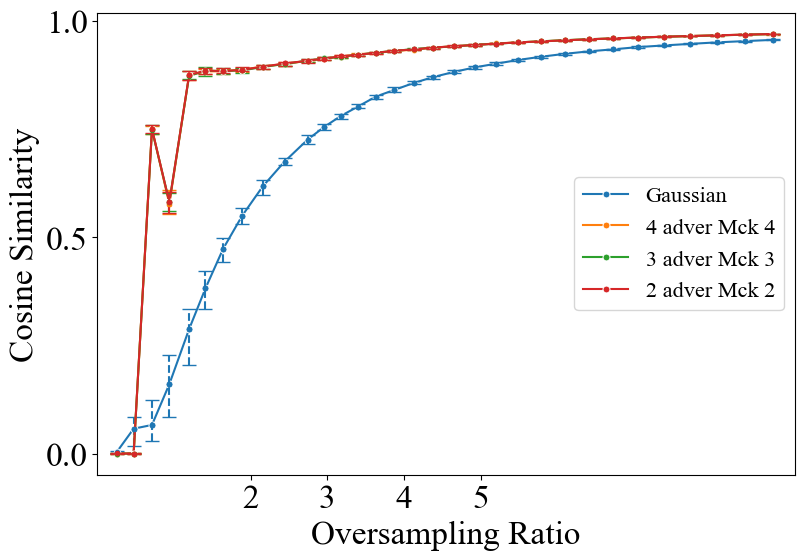

In [29]:
plot_error_bars(
    [
        df_gaussian["oversampling_ratio"],
        df_4adver4_mck["oversampling_ratio"],
        df_3adver3_mck["oversampling_ratio"],
        df_2adver2_mck["oversampling_ratio"],
    ],
    [
        df_gaussian,
        df_4adver4_mck,
        df_3adver3_mck,
        df_2adver2_mck,
    ],
    [
        "Gaussian",
        "4 adver Mck 4",
        "3 adver Mck 3",
        "2 adver Mck 2",
    ],
    #title="Performance Comparison of Different Number of Layers",
    #save="layers_gd_spec.svg",
    figsize=(9,6),
    plot="n_layers",
    xlim=(0.0,9.1),
    xticks=[2,3,4,5],
    yticks=[0.0,0.5,1.0],
    legend_loc="center right",
    labelsize=24,
    fontsize=16,
    #save_dir='paper/figures/layers.pdf',
    ticksize=24,
    transparent=True
)

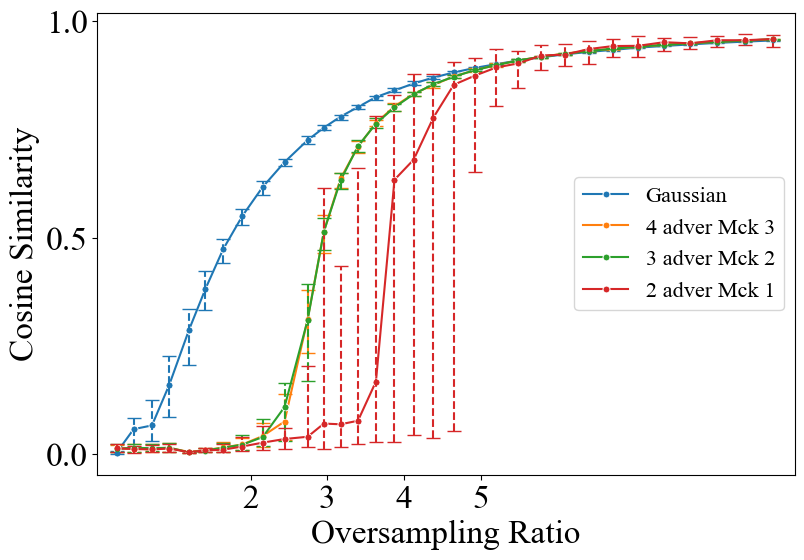

In [30]:
plot_error_bars(
    [
        df_gaussian["oversampling_ratio"],
        df_4adver3_mck["oversampling_ratio"],
        df_3adver2_mck["oversampling_ratio"],
        df_2adver1_mck["oversampling_ratio"],
    ],
    [
        df_gaussian,
        df_4adver3_mck,
        df_3adver2_mck,
        df_2adver1_mck,
    ],
    [
        "Gaussian",
        "4 adver Mck 3",
        "3 adver Mck 2",
        "2 adver Mck 1",
    ],
    #title="Performance Comparison of Different Number of Layers",
    #save="layers_gd_spec.svg",
    figsize=(9,6),
    plot="n_layers",
    xlim=(0.0,9.1),
    xticks=[2,3,4,5],
    yticks=[0.0,0.5,1.0],
    legend_loc="center right",
    labelsize=24,
    fontsize=16,
    #save_dir='paper/figures/layers.pdf',
    ticksize=24,
    transparent=True
)

Figure saved to ../figures/adver.pdf


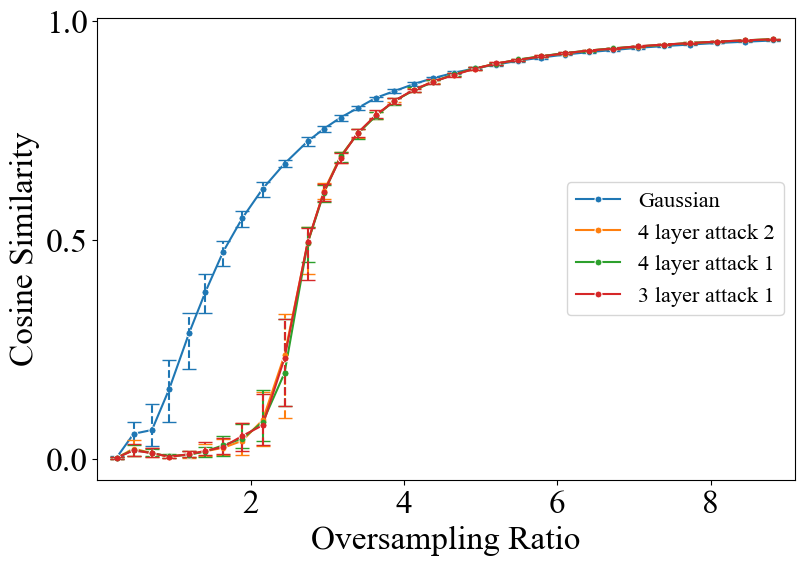

In [31]:
plot_error_bars(
    [
        df_gaussian["oversampling_ratio"],
        df_4adver2_mck["oversampling_ratio"],
        df_4adver1_mck["oversampling_ratio"],
        df_3adver1_mck["oversampling_ratio"],
    ],
    [
        df_gaussian,
        df_4adver2_mck,
        df_4adver1_mck,
        df_3adver1_mck,
    ],
    [
        "Gaussian",
        "4 layer attack 2",
        "4 layer attack 1",
        "3 layer attack 1",
    ],
    figsize=(9,6),
    plot="n_layers",
    xlim=(0.0,9.1),
    xticks=[2,4,6,8],
    yticks=[0.0,0.5,1.0],
    legend_loc="center right",
    labelsize=24,
    fontsize=16,
    save_dir='../figures/adver.pdf',
    ticksize=24,
    transparent=True
)

# Marchenko (sorted)

In [43]:
df_gaussian = pd.read_csv("../results/full/marchenko/full_marchenko_spec.csv")
df_gaussian_2 = pd.read_csv("../results/full/gaussian_square/full_gaussian_square_spec.csv")
df_gaussian_3 = pd.read_csv("../results/full/gaussian_cubic/full_gaussian_cubic_spec.csv")
df_gaussian_4 = pd.read_csv("../results/full/gaussian_quartic/full_gaussian_quartic_spec.csv")

df_struct_marchenko = pd.read_csv("../results/structured/marchenko_fourier_uniform/structured_fourier_marchenko_FDFD_spec.csv")
df_marchenko_square = pd.read_csv("../results/structured/marchenko_square_fourier_uniform/structured_marchenko_square_FDFD_spec.csv")
df_marchenko_cubic = pd.read_csv("../results/structured/marchenko_cubic_fourier_uniform/structured_marchenko_cubic_FDFDFD_spec.csv")
df_marchenko_quartic = pd.read_csv("../results/structured/marchenko_quartic_fourier_uniform/structured_marchenko_quartic_FDFDFDFD_spec.csv")
df_marchenko_quintic = pd.read_csv("../results/structured/marchenko_quintic_fourier_uniform/structured_marchenko_quintic_FDFDFDFDFD_spec.csv")
df_marchenko_hexic = pd.read_csv("../results/structured/marchenko_hexic_fourier_uniform/structured_marchenko_hexic_FDFDFDFDFDFD_spec.csv")

In [39]:
clean_df([df_struct_marchenko, df_marchenko_square, df_marchenko_cubic, df_marchenko_quartic, df_marchenko_quintic, df_marchenko_hexic], start=0.0)

Gaussian
(0.12156862745098039, 0.4666666666666667, 0.7058823529411765) Gaussian
Gaussian * 2
(1.0, 0.4980392156862745, 0.054901960784313725) Gaussian * 2
Marchenko * 2
(0.17254901960784313, 0.6274509803921569, 0.17254901960784313) Marchenko * 2
Figure saved to ../figures/marchenko_square.pdf


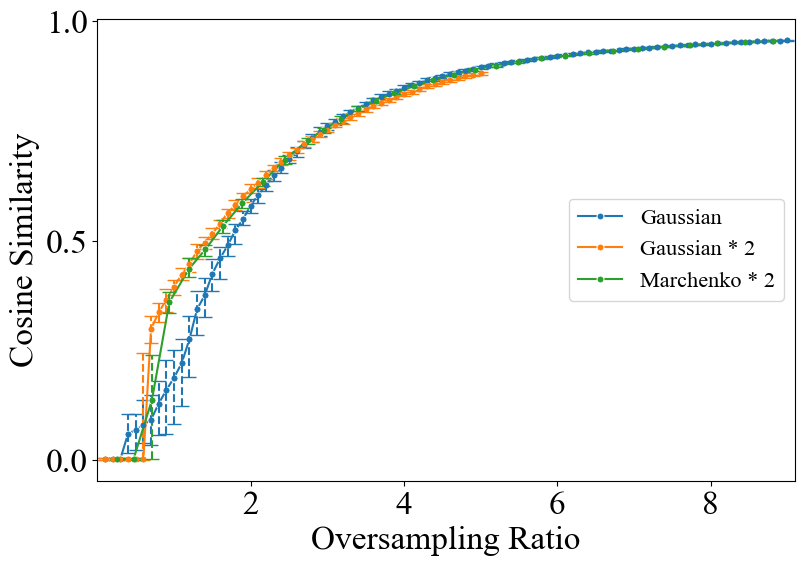

In [40]:
# plot
plot_error_bars(
    oversamplings=[
        df_gaussian["oversampling_ratio"],
        df_gaussian_2["oversampling_ratio"],
        df_marchenko_square["oversampling_ratio"],
    ],
    datasets=[
        df_gaussian,
        df_gaussian_2,
        df_marchenko_square,
    ],
    labels=[
        "Gaussian",
        "Gaussian * 2",
        "Marchenko * 2",
    ],
    #title="Performance Comparison of Different Number of Layers",
    #save="layers_gd_spec.svg",
    figsize=(9,6),
    plot="n_layers",
    xlim=(0.0,9.1),
    xticks=[2,4,6,8],
    yticks=[0.0,0.5,1.0],
    legend_loc="center right",
    labelsize=24,
    fontsize=16,
    save_dir='../figures/marchenko_square.pdf',
    ticksize=24,
    transparent=True
)

Gaussian
(0.12156862745098039, 0.4666666666666667, 0.7058823529411765) Gaussian
Gaussian * 3
(1.0, 0.4980392156862745, 0.054901960784313725) Gaussian * 3
Marchenko * 3
(0.17254901960784313, 0.6274509803921569, 0.17254901960784313) Marchenko * 3
Figure saved to ../figures/marchenko_cubic.pdf


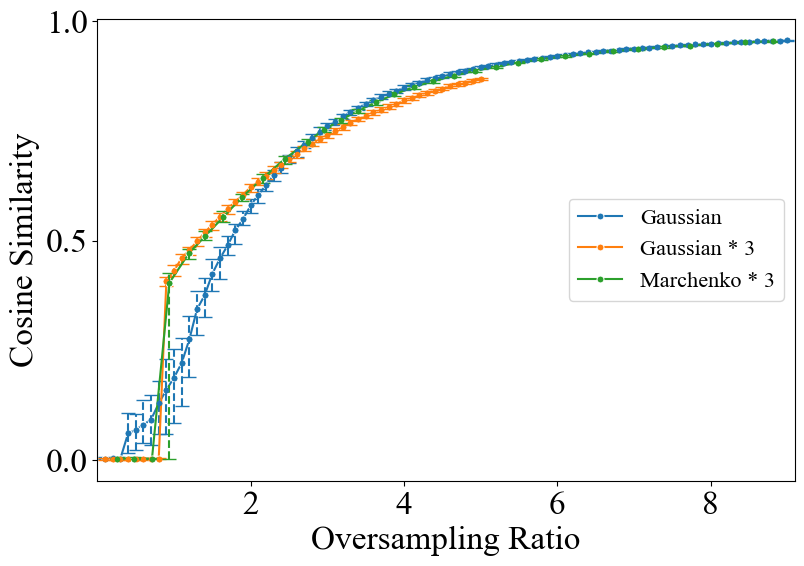

In [41]:
# plot
plot_error_bars(
    oversamplings=[
        df_gaussian["oversampling_ratio"],
        df_gaussian_3["oversampling_ratio"],
        df_marchenko_cubic["oversampling_ratio"],
    ],
    datasets=[
        df_gaussian,
        df_gaussian_3,
        df_marchenko_cubic,
    ],
    labels=[
        "Gaussian",
        "Gaussian * 3",
        "Marchenko * 3",
    ],
    #title="Performance Comparison of Different Number of Layers",
    #save="layers_gd_spec.svg",
    figsize=(9,6),
    plot="n_layers",
    xlim=(0.0,9.1),
    xticks=[2,4,6,8],
    yticks=[0.0,0.5,1.0],
    legend_loc="center right",
    labelsize=24,
    fontsize=16,
    save_dir='../figures/marchenko_cubic.pdf',
    ticksize=24,
    transparent=True
)

Gaussian
(0.12156862745098039, 0.4666666666666667, 0.7058823529411765) Gaussian
Gaussian * 4
(1.0, 0.4980392156862745, 0.054901960784313725) Gaussian * 4
Marchenko * 4
(0.17254901960784313, 0.6274509803921569, 0.17254901960784313) Marchenko * 4
Figure saved to ../figures/marchenko_quartic.pdf


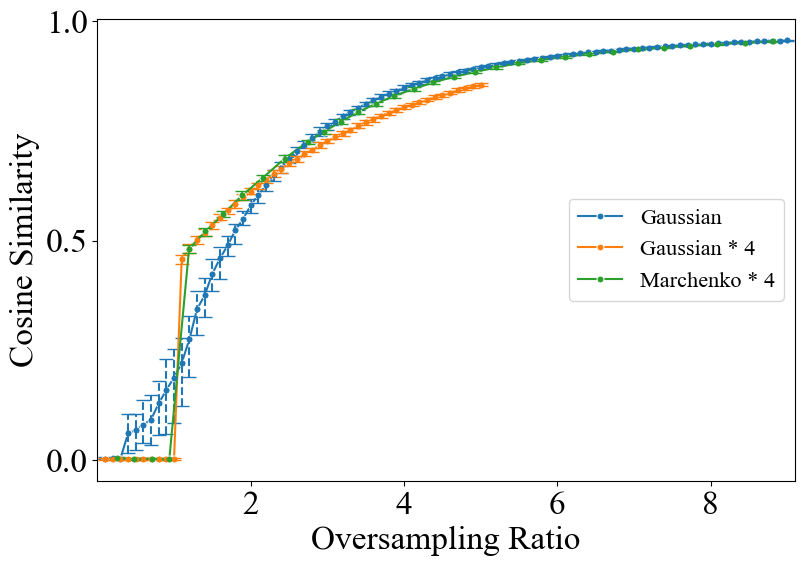

In [42]:
plot_error_bars(
    oversamplings=[
        df_gaussian["oversampling_ratio"],
        df_gaussian_4["oversampling_ratio"],
        df_marchenko_quartic["oversampling_ratio"],
    ],
    datasets=[
        df_gaussian,
        df_gaussian_4,
        df_marchenko_quartic,
    ],
    labels=[
        "Gaussian",
        "Gaussian * 4",
        "Marchenko * 4",
    ],
    figsize=(9,6),
    plot="n_layers",
    xlim=(0.0,9.1),
    xticks=[2,4,6,8],
    yticks=[0.0,0.5,1.0],
    legend_loc="center right",
    labelsize=24,
    fontsize=16,
    save_dir='../figures/marchenko_quartic.pdf',
    ticksize=24,
    transparent=True
)

# 2 layers controlled spectrum (sorted)

In [51]:
df_gaussian = pd.read_csv("../results/full/marchenko/full_marchenko_spec.csv")
df_gaussian_2 = pd.read_csv("../results/full/gaussian_square/full_gaussian_square_spec.csv")
df_gaussian_3 = pd.read_csv("../results/full/gaussian_cubic/full_gaussian_cubic_spec.csv")
df_gaussian_4 = pd.read_csv("../results/full/gaussian_quartic/full_gaussian_quartic_spec.csv")

df_2emulate2 = pd.read_csv("../results/structured/emulate_square_fourier_uniform/structured_emulate2_FDFD_spec.csv")
df_2emulate3 = pd.read_csv("../results/structured/emulate_cubic_fourier_uniform/structured_emulate3_FDFD_spec.csv")
df_2emulate4 = pd.read_csv("../results/structured/emulate_quartic_fourier_uniform/structured_emulate4_FDFD_spec.csv")

In [52]:
clean_df([df_2emulate3, df_2emulate2, df_2emulate4], start=0.0)

Gaussian
(0.12156862745098039, 0.4666666666666667, 0.7058823529411765) Gaussian
Gaussian * 2
(1.0, 0.4980392156862745, 0.054901960784313725) Gaussian * 2
Controlled Spectrum 2
(0.17254901960784313, 0.6274509803921569, 0.17254901960784313) Controlled Spectrum 2
Figure saved to ../figures/control2.pdf


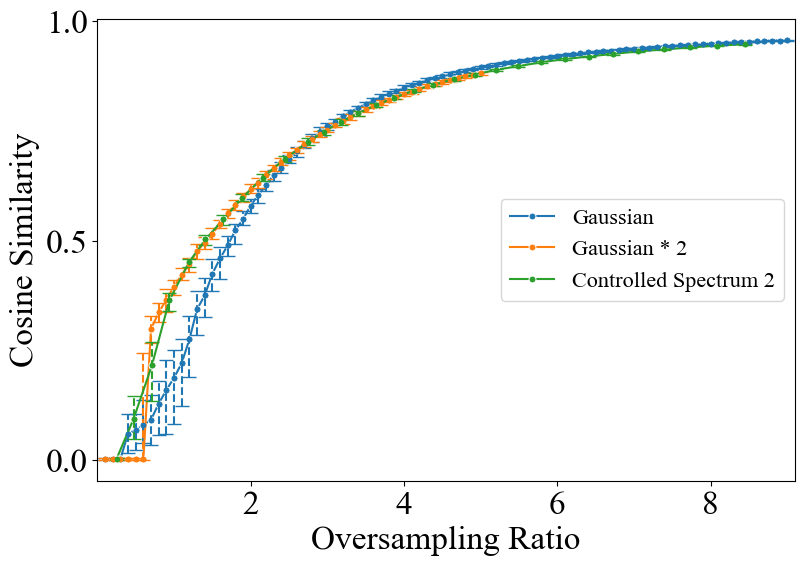

In [53]:
plot_error_bars(
    [
        df_gaussian["oversampling_ratio"],
        df_gaussian_2["oversampling_ratio"],
        df_2emulate2["oversampling_ratio"],
    ],
    [
        df_gaussian,
        df_gaussian_2,
        df_2emulate2,
    ],
    [
        "Gaussian",
        "Gaussian * 2",
        "Controlled Spectrum 2",
    ],
    figsize=(9,6),
    plot="n_layers",
    xlim=(0.0,9.1),
    xticks=[2,4,6,8],
    yticks=[0.0,0.5,1.0],
    legend_loc="center right",
    labelsize=24,
    fontsize=16,
    save_dir='../figures/control2.pdf',
    ticksize=24,
    transparent=True
)

Gaussian
(0.12156862745098039, 0.4666666666666667, 0.7058823529411765) Gaussian
Gaussian * 3
(1.0, 0.4980392156862745, 0.054901960784313725) Gaussian * 3
Controlled Spectrum 3
(0.17254901960784313, 0.6274509803921569, 0.17254901960784313) Controlled Spectrum 3
Figure saved to ../figures/control3.pdf


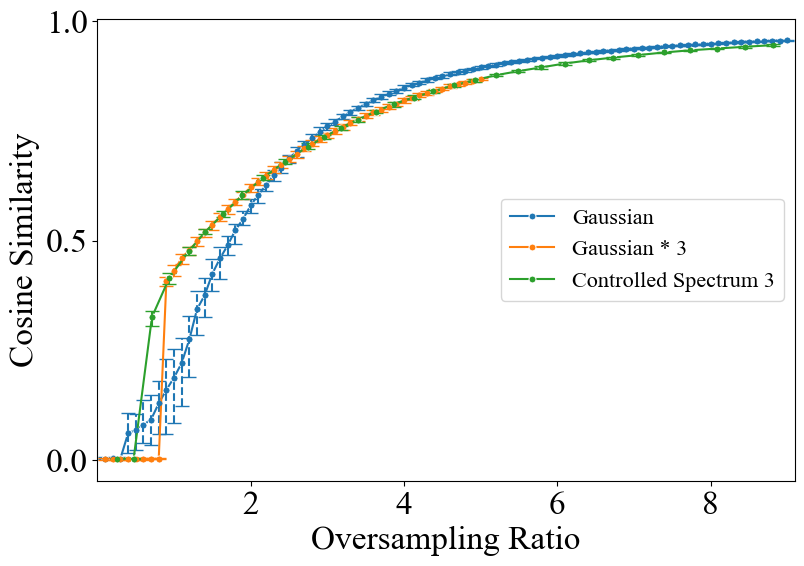

In [54]:
plot_error_bars(
    [
        df_gaussian["oversampling_ratio"],
        df_gaussian_3["oversampling_ratio"],
        df_2emulate3["oversampling_ratio"],
    ],
    [
        df_gaussian,
        df_gaussian_3,
        df_2emulate3,
    ],
    [
        "Gaussian",
        "Gaussian * 3",
        "Controlled Spectrum 3",
    ],
    figsize=(9,6),
    plot="n_layers",
    xlim=(0.0,9.1),
    xticks=[2,4,6,8],
    yticks=[0.0,0.5,1.0],
    legend_loc="center right",
    labelsize=24,
    fontsize=16,
    save_dir='../figures/control3.pdf',
    ticksize=24,
    transparent=True
)

Gaussian
(0.12156862745098039, 0.4666666666666667, 0.7058823529411765) Gaussian
Gaussian * 4
(1.0, 0.4980392156862745, 0.054901960784313725) Gaussian * 4
Controlled Spectrum 4
(0.17254901960784313, 0.6274509803921569, 0.17254901960784313) Controlled Spectrum 4
Figure saved to ../figures/control4.pdf


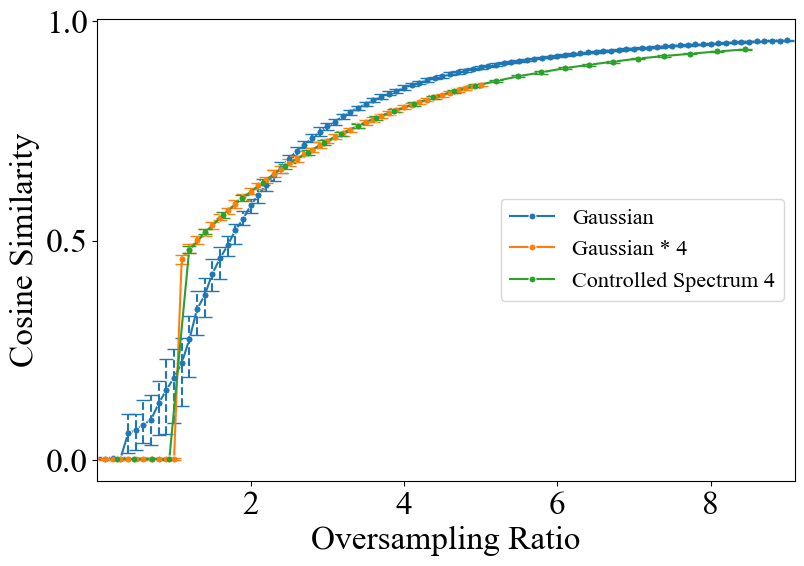

In [55]:

plot_error_bars(
    [
        df_gaussian["oversampling_ratio"],
        df_gaussian_4["oversampling_ratio"],
        df_2emulate4["oversampling_ratio"],
    ],
    [
        df_gaussian,
        df_gaussian_4,
        df_2emulate4,
    ],
    [
        "Gaussian",
        "Gaussian * 4",
        "Controlled Spectrum 4",
    ],
    figsize=(9,6),
    plot="n_layers",
    xlim=(0.0,9.1),
    xticks=[2,4,6,8],
    yticks=[0.0,0.5,1.0],
    legend_loc="center right",
    labelsize=24,
    fontsize=16,
    save_dir='../figures/control4.pdf',
    ticksize=24,
    transparent=True
)

# Reconstruction Visualization (sorted)

torch.Size([1, 1, 128, 128])


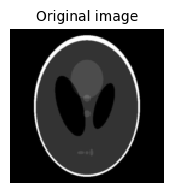

In [8]:
# generate signal
img_size = 128
url = get_image_url("SheppLogan.png")
x = load_url_image(
    url=url, img_size=img_size, grayscale=True, resize_mode="resize", device=device
)
print(x.shape)
plot(x, titles="Original image",fontsize=10)

# generate phase signal

# The phase is computed as 2*pi*x - pi, where x is the original image.
x_phase = torch.exp(1j*x*torch.pi - 0.5j*torch.pi).to(device)

# Every element of the signal should have unit norm.
assert torch.allclose(x_phase.real**2 + x_phase.imag**2, torch.tensor(1.0))

In [9]:
# create 3 models with different oversampling: 2.0, 2.5, 3.0

output_sizes = {1:180, 2:202, 3:221}
recons = [x]

for i in range(1,4):
    physics = dinv.physics.StructuredRandomPhaseRetrieval(
        n_layers=2,
        input_shape=(1, img_size, img_size),
        output_shape=(1, output_sizes[i], output_sizes[i]),
        drop_tail=True,
        shared_weights=True,
        dtype = torch.cfloat,
        device=device,
    )

    y = physics.forward(x_phase)

    params_algo = {"stepsize": 6e-3*physics.oversampling_ratio.item(), "g_params": 0.00}

    model = optim_builder(
        iteration="PGD",
        prior=dinv.optim.prior.Zero(),
        data_fidelity=dinv.optim.data_fidelity.L2(),
        early_stop=True,
        max_iter=20000,
        verbose=False,
        params_algo=params_algo,
        custom_init=spectral_methods_wrapper,
    )

    x_phase_recon = model(y, physics, x_gt=x_phase)
    x_phase_recon = correct_global_phase(x_phase_recon,x_phase)
    x_recon = torch.angle(x_phase_recon) / (2*torch.pi) + 0.5
    recons.append(x_recon)

Image 0, channel 0 does not have a global phase shift.
Power iteration early stopping at iteration 4680.
Image 0, channel 0 does not have a global phase shift.
Power iteration early stopping at iteration 1911.
Image 0, channel 0 does not have a global phase shift.


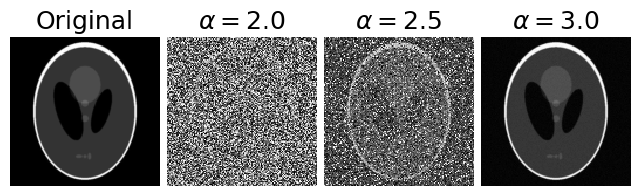

In [16]:
# visuliazation
plot(recons, figsize=(8,3), titles=["Original",r"$\alpha=2.0$", r"$\alpha=2.5$", r"$\alpha=3.0$"],save='paper/figures/recons.pdf',fontsize=18,transparent=True,)

# Reconstruction Accuracy (sorted)

In [ ]:
load_path = Path("/home/zhhu/workspaces/deepinv/experimental/results/accuracy")

In [15]:
df_random_gd_spec = pd.read_csv(load_path/"res_random_gd_spectral_100repeat_10000iter_0.10000000149011612-9.0.csv")
df_random_gd_spec_small = pd.read_csv(load_path /"res_random_gd_spectral_100repeat_10000iter_2.0-2.5999999046325684.csv")
df_random_spec = pd.read_csv(load_path /"res_random_spectral_100repeat_5000iter_0.10000000149011612-9.0.csv")
df_random_gd_rand = pd.read_csv(load_path /"res_random_gd_random_100repeat_10000iter_0.10000000149011612-9.0.csv")
df_structured_gd_spec = pd.read_csv(load_path /"res_structured_gd_spectral_100repeat_10000iter_0.0001020304043777287-9.0.csv")
df_structured_spec = pd.read_csv(load_path /"res_structured_2_spectral_100repeat_5000iter_0.0009765625-9.0.csv")
df_structured_gd_rand = pd.read_csv(load_path /"res_structured_2_gd-rand_100repeat_10000iter_0.0009765625-9.0.csv")

In [ ]:
df_structured_spec.head(n=15)
df_structured_gd_spec.dtypes

In [17]:
for oversampling_ratio in [2.0,2.1,2.2,2.3,2.4,2.5,2.6]:
    df_random_gd_spec.loc[df_random_gd_spec["oversampling_ratio"] == oversampling_ratio] = df_random_gd_spec_small.loc[df_random_gd_spec_small["oversampling_ratio"] == oversampling_ratio].values

In [19]:
for df in [df_random_gd_spec, df_random_spec, df_random_gd_rand]:
    rows_to_drop = []
    for index, row in df.iterrows():
        if round(row['oversampling_ratio']*10) % 2 != 0 and row['oversampling_ratio']< 3.0:
            rows_to_drop.append(index)

    df.drop(rows_to_drop, inplace=True)

In [20]:
for df in [df_structured_gd_rand, df_structured_gd_spec, df_structured_spec]:
    rows_to_drop = []
    left = -0.15
    for index, row in df.iterrows():
        if row["oversampling_ratio"] - left < 0.2:
            rows_to_drop.append(index)
        else:
            left = row["oversampling_ratio"]
    df.drop(rows_to_drop, inplace=True) 

In [21]:
oversampling_ratios_random_gd_spec = df_random_gd_spec["oversampling_ratio"]
oversampling_ratios_random_spec = df_random_spec["oversampling_ratio"]
oversampling_ratios_random_gd_rand = df_random_gd_rand["oversampling_ratio"]
oversampling_ratios_structured_gd_spec = df_structured_gd_spec["oversampling_ratio"]
oversampling_ratios_structured_spec = df_structured_spec["oversampling_ratio"]
oversampling_ratios_structured_gd_rand = df_structured_gd_rand["oversampling_ratio"]

iid gd spec
(0.12156862745098039, 0.47058823529411764, 0.7058823529411765) iid gd spec
iid spec
(0.12156862745098039, 0.47058823529411764, 0.7058823529411765) iid spec
iid gd rand
(0.12156862745098039, 0.47058823529411764, 0.7058823529411765) iid gd rand
structured gd spec
(1.0, 0.4980392156862745, 0.0) structured gd spec
structured spec
(1.0, 0.4980392156862745, 0.0) structured spec
structured gd rand
(1.0, 0.4980392156862745, 0.0) structured gd rand
Figure saved to paper/figures/accuracy.pdf


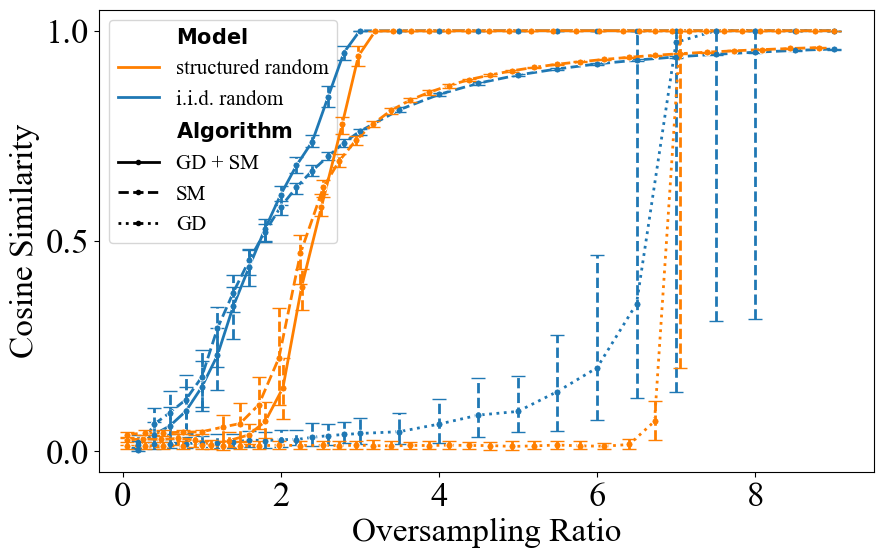

In [22]:
plot_error_bars([oversampling_ratios_random_gd_spec,
                 oversampling_ratios_random_spec,oversampling_ratios_random_gd_rand,oversampling_ratios_structured_gd_spec,oversampling_ratios_structured_spec,
                 oversampling_ratios_structured_gd_rand],
                [df_random_gd_spec,
                 df_random_spec,
                 df_random_gd_rand,
                 df_structured_gd_spec,
                 df_structured_spec,
                 df_structured_gd_rand],
                ['iid gd spec',
                 'iid spec',
                 'iid gd rand',
                 'structured gd spec',
                 'structured spec',
                 'structured gd rand'],
                figsize=(10,6),
                font="Times New Roman",
                fontsize=15,
                labelsize=24,
                xlim=(-0.3,9.5),
                yticks=[0.0,0.5,1.0],
                error_bar_linestyle="--",
                structured_color=sns.color_palette("Paired")[7],
                iid_color=sns.color_palette("Paired")[1],
                plot='reconstruction',
                ticksize=25,
                show=False,
                save_dir='paper/figures/accuracy.pdf')

# Time Complexity (sorted)

In [ ]:
load_path = Path("/home/zhhu/workspaces/deepinv/experimental/results/time")

In [24]:
df_random_cpu = pd.read_csv(load_path / "df_random_cpu.csv")
df_random_gpu = pd.read_csv(load_path / "df_random_gpu.csv")
df_structured_cpu = pd.read_csv(load_path / "df_structured_cpu.csv")
df_structured_gpu = pd.read_csv(load_path / "df_structured_gpu.csv")

In [25]:
df_random_gpu.iloc[0]["img_size_8"] = None
df_random_gpu

/tmp/ipykernel_3498706/1141376657.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_random_gpu.iloc[0]["img_size_8"] = None


,img_size_8,img_size_16,img_size_32,img_size_64,img_size_96,img_size_128,img_size_160,img_size_192,img_size_224,img_size_240
0,NaN,0.000501,0.000638,0.000540,0.001046,0.003431,0.007872,0.016202,0.029026,0.031205
1,0.000252,0.000467,0.000466,0.000386,0.001200,0.003330,0.007773,0.016022,0.023464,0.031089
2,0.000179,0.000460,0.000462,0.000367,0.001196,0.003243,0.007803,0.016826,0.023490,0.031042
3,0.000170,0.000459,0.000453,0.000364,0.001208,0.003246,0.007780,0.016126,0.023477,0.031130
4,0.000168,0.000459,0.000451,0.000364,0.001168,0.003349,0.007809,0.015985,0.023582,0.031191
...,...,...,...,...,...,...,...,...,...,...
95,0.000164,0.000173,0.000174,0.000299,0.001241,0.003373,0.007748,0.016134,0.023584,0.031102
96,0.000164,0.000172,0.000170,0.000296,0.001233,0.003400,0.007826,0.016018,0.023588,0.030983
97,0.000164,0.000172,0.000168,0.000296,0.001230,0.003401,0.007770,0.016045,0.023482,0.031095
98,0.000165,0.000174,0.000168,0.000297,0.001246,0.003392,0.007826,0.015952,0.023474,0.031016


In [26]:
img_sizes_iid: list[int] = [8, 16, 32, 64, 96, 128, 160, 192, 224, 240]
img_sizes_structured: list[int] = [8, 16, 32, 64, 96, 128, 160, 192, 224, 240]
num_pixels_iid = [img_sizes_iid**2 for img_sizes_iid in img_sizes_iid]
num_pixels_structured = [img_sizes_structured**2 for img_sizes_structured in img_sizes_structured]

i.i.d. random (CPU)
(0.12156862745098039, 0.4666666666666667, 0.7058823529411765) i.i.d. random (CPU)
i.i.d. random (GPU)
(1.0, 0.4980392156862745, 0.054901960784313725) i.i.d. random (GPU)
structured random (CPU)
(0.17254901960784313, 0.6274509803921569, 0.17254901960784313) structured random (CPU)
structured random (GPU)
(0.8392156862745098, 0.15294117647058825, 0.1568627450980392) structured random (GPU)
Figure saved to paper/figures/time.pdf


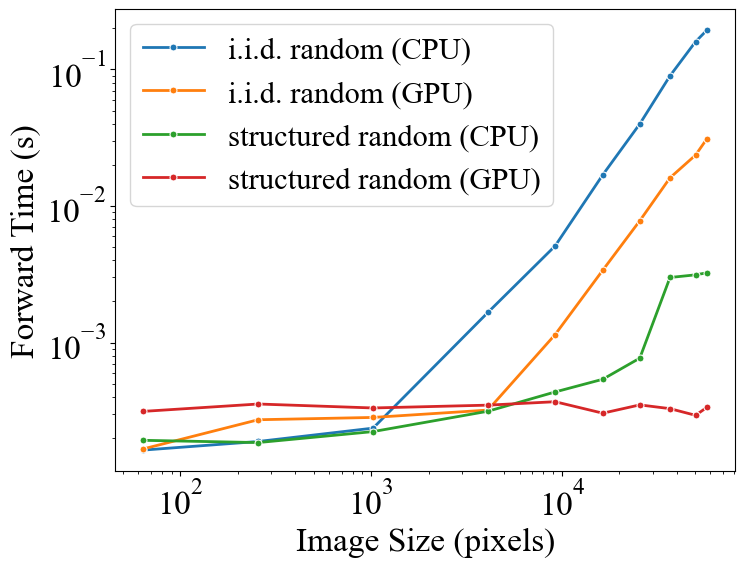

In [27]:
plot_error_bars([num_pixels_iid,
                 num_pixels_iid,
                 num_pixels_structured,
                 num_pixels_structured],
                [df_random_cpu,
                 df_random_gpu,
                 df_structured_cpu,
                 df_structured_gpu],
                ['i.i.d. random (CPU)','i.i.d. random (GPU)','structured random (CPU)','structured random (GPU)'],
                axis=0,
                figsize=(8,6),
                xscale='log',
                yscale='log',
                xlabel='Image Size (pixels)',
                ylabel='Forward Time (s)',
                legend_loc='upper left',
                plot='time',
                error_bar='std',
                save_dir='paper/figures/time.pdf',
                fontsize=22,
                labelsize=24,
                ticksize=24,
                bbox_inches = 'tight')